In [11]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
#import pymc3
import math
import arviz as az
#from hpd import hpd
import scipy.stats as stats
from io import StringIO
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()
import seaborn as sns
from matplotlib import gridspec
from zipfile import ZipFile
import scipy as sp


import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap


from scipy.special import binom
typeface='Helvetica Neue'

mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])

def metricDistance(pointA,pointB):
    """ Calculate distance in kilometers along planet's surface from longitude and latitude. """
    R=6371 ## kilometers
    lon1,lat1=pointA
    lon2,lat2=pointB
    
    phi1=math.radians(lat1)
    phi2=math.radians(lat2)
    
    deltaPhi=math.radians(lat2-lat1)
    deltaLam=math.radians(lon2-lon1)
    
    a=math.sin(deltaPhi/2.0) * math.sin(deltaPhi/2.0) + math.cos(phi1) * math.cos(phi2) * math.sin(deltaLam/2.0) * math.sin(deltaLam/2.0)
    c = 2.0 * math.atan2(math.sqrt(a),math.sqrt(1-a))
    
    return R*c

def Bezier_control(pointA,pointB,height,frac):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance (height) that defines a line perpendicular to line AB which intercepts AB at fraction (frac) along AB.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB

    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2) ## distance between points
    
    h=np.sqrt(height**2+(d*frac)**2) ## distance between desired height and point along line

    n1=x1+h*np.cos(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign ## magic
    n2=y1+h*np.sin(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign

    return (n1,n2) ## return third point's coordinate

In [12]:
masked_regions = pd.read_csv("../scripts/masked.txt", sep ='\t', header = None, names = ["region"])

In [13]:
masked_regions

,region
4061_SouthernEurope_2022-05-20,Southern Europe
8887_SouthernEurope_2022-06-06,Southern Europe
9000398_WesternEurope_2022-09-01,Western Europe
9000422_WesternEurope_2022-08-01,Western Europe
9000431_WesternEurope_2022-09-01,Western Europe
...,...
MPXV/Human/USA/CA-LACPHL-MA00288/2022_NorthAmerica_2022-10-04,North America
MPX/Human/USA/CA-LACPHL-MA00142/2022_NorthAmerica_2022-08-29,North America
hMPX/Human/USA/CA-LACPHL-MA00053/2022_NorthAmerica_2022-07-25,North America
MPX/Human/USA/CA-LACPHL-MA00237/2022_NorthAmerica_2022-07-20,North America


In [14]:
# log_paths=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_genome.GLM.log'%(i) for i in range(5)]
# log_paths+=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_gp.GLM.log'%(i) for i in range(5)]
log_path='/Users/mparedes/Desktop/emp_test_fixed_region_pre_sub_1000.log'
data={}
burnin=20000000
log = "region"

for line in open(log_path,'r'):
    if '#' not in line:
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            
            data[log]={x:[] for i,x in enumerate(header)}
        elif len(l)==len(header) and int(l[0])>burnin:
            for i,x in enumerate(l):
                if 'age(' in header[i]:
                    data[log][header[i]].append(2016.0-float(x))
                elif 'ucld' in header[i] or 'meanRate' in header[i]:
                    data[log][header[i]].append(float(x))

                if header[i] in ['state','prior','likelihood','posterior']:
                    data[log][header[i]].append(float(x))



In [15]:
data

{'region': {'state': [20005000.0,
   20010000.0,
   20015000.0,
   20020000.0,
   20025000.0,
   20030000.0,
   20035000.0,
   20040000.0,
   20045000.0,
   20050000.0,
   20055000.0,
   20060000.0,
   20065000.0,
   20070000.0,
   20075000.0,
   20080000.0,
   20085000.0,
   20090000.0,
   20095000.0,
   20100000.0,
   20105000.0,
   20110000.0,
   20115000.0,
   20120000.0,
   20125000.0,
   20130000.0,
   20135000.0,
   20140000.0,
   20145000.0,
   20150000.0,
   20155000.0,
   20160000.0,
   20165000.0,
   20170000.0,
   20175000.0,
   20180000.0,
   20185000.0,
   20190000.0,
   20195000.0,
   20200000.0,
   20205000.0,
   20210000.0,
   20215000.0,
   20220000.0,
   20225000.0,
   20230000.0,
   20235000.0,
   20240000.0,
   20245000.0,
   20250000.0,
   20255000.0,
   20260000.0,
   20265000.0,
   20270000.0,
   20275000.0,
   20280000.0,
   20285000.0,
   20290000.0,
   20295000.0,
   20300000.0,
   20305000.0,
   20310000.0,
   20315000.0,
   20320000.0,
   20325000.0,
   203

In [16]:
tree_path = "/Users/mparedes/Desktop/mcc_empirical_tree_1000_dta.tree"
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2023.0068)

In [17]:
colours = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

100


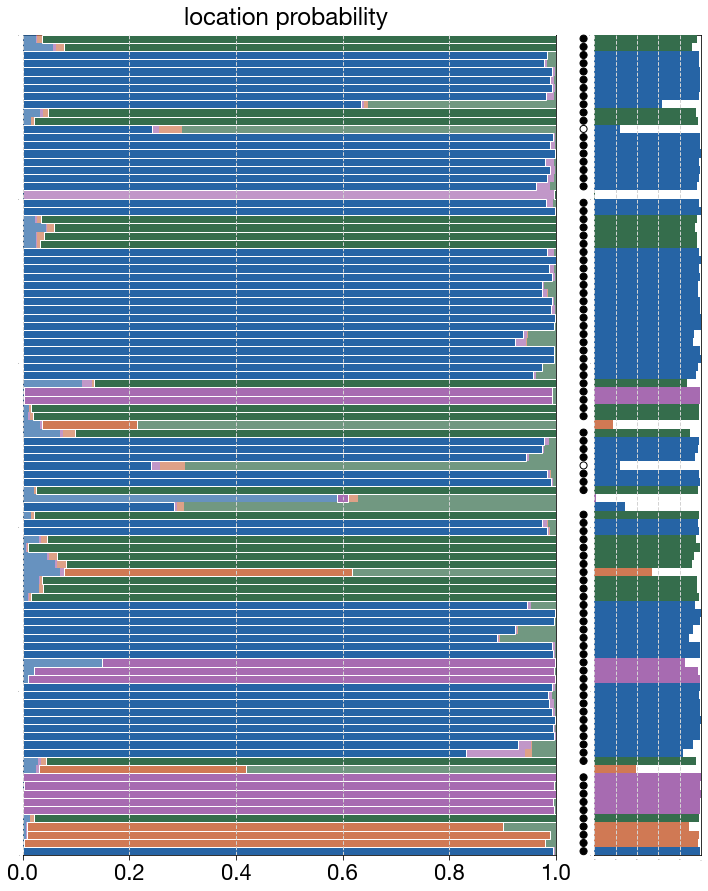

In [20]:
fig = plt.figure(figsize=(25, 25),facecolor='w') 

L=len(data)
L=2
locations = ["CentralEurope", "NorthAmerica", "SouthAmerica", "SouthernEurope", "WesternEurope"]

gs = gridspec.GridSpec(2, 2*L,height_ratios=[5,1],width_ratios=[5,1]*L,wspace=0.12,hspace=0.12,bottom=0.3) ## setup figure with two columns

masked_tip_names= masked_regions.index[masked_regions.region == "?"].tolist()
print(len(masked_tip_names))

locTrait='region'
calibration={0:[],1:[]} ## will contain data for calibration later

for idx,ll in enumerate([tree]): ## iterate over genome and GP trees
    D=[]
    ax = plt.subplot(gs[0,idx*L]) ## probabilities
    ax1 = plt.subplot(gs[0,idx*L+1]) ## one probability
    #ax2 = plt.subplot(gs[1,idx*L:idx*L+2]) ## KDEs

    i=0
    entropy=0.0
    inf=0

    correctCount=0
    max_guesses=[] ## keep track of how confident model is about the most likely location
    correct=[]
    masked_tips=[w for w in ll.Objects if w.branchType=='leaf' ]
   # print(masked_tips)
    truths=[]
    predicts=[]
    
    
  #  out=open('/Users/evogytis/Downloads/Fig3_locations_%s.tsv'%(label),'w')
 #   out.write('tip\tloc\tloc prob\t%s\tin 95 set\n'%(' prob\t'.join(sorted(locations,key=lambda q:(location_to_country[q],-normalized_coords[q])))))
    for k in masked_tips: ## iterate over tips
    
        if k.name in masked_tip_names: ## if tip masked
            d=[] ## start new list for distances
            true_loc=k.name.split('_')[-2] ## get correct location
           # print(k.name)
            #print(true_loc)
            #true_coord=popCentres[true_loc] ## get population centroid for correct location

            inferred={x:y for x,y in zip(k.traits['%s.set'%(locTrait)],k.traits['%s.set.prob'%(locTrait)])} ## create dictionary of posterior guesses
            
            for loc in locations: ## iterate through all locations
                if loc not in inferred: ## if missing - assign probability 0
                    inferred[loc]=0.0
            
            sorted_set=sorted(inferred.keys(),key=lambda x:-inferred[x]) ## sort states according to probability from highest to lowest
            sorted_probs=[inferred[x] for x in sorted_set] ## get probabilities
            
            if sorted_probs[0]>0.95:
                mostProbableSet=[sorted_set[0]]
            else:
                mostProbableSet=[sorted_set[x] for x in range(len(sorted_set)) if sum(sorted_probs[:x+1])<0.95] ## cumulative sum of probabilities until you hit 95% or if first state is >95%
            
            inSet=true_loc in mostProbableSet ## bool: is true location in the 95% set?
            
            if inSet:
                ax1.scatter(-0.1,i+0.5,s=50,edgecolor='k',facecolor='none',clip_on=False)
            
            if (true_loc in inferred) and inSet: ## if correct location not among guesses
                correct.append(inferred[true_loc]) ## add probability to list
            else:
                inf+=1
                correct.append(0.0) ## add zero otherwise
            
            max_guesses.append(max(inferred.values())) ## log best guess
            bestGuess=[w for w in inferred if inferred[w]==max(inferred.values())][-1] ## get best guess
            
            if bestGuess==true_loc: ## count if best guess is correct
                correctCount+=1
                calibration[idx].append((inferred[bestGuess],1)) ## log probability, 1 for correct
                ax1.scatter(-0.1,i+0.5,s=50,edgecolor='none',facecolor='k',clip_on=False)
            else:
                calibration[idx].append((inferred[bestGuess],0)) ## log probability, 0 for incorrect
                
            #out.write('%s\t%s\t%s\t%s\t%s\n'%(k.name,true_loc,inferred[true_loc],'\t'.join([str(inferred[w]) for w in sorted(locations,key=lambda q:(location_to_country[q],-normalized_coords[q]))]),inSet))
            p=0.0
            tip_distance=0.0
            for loc in sorted(locations): ## iterate over all locations
                prob=inferred[loc] ## get probability of guess
#                infer_coord=popCentres[loc] ## get coordinate of guess
 #               distance=metricDistance(true_coord,infer_coord)*prob ## multiply pop centroid distance by guess probability
#                 d.append(distance) ## remember guess distance
  #              tip_distance+=distance
                fc=colours[loc] ## get colour
                ec='none'

                h=''
                al=0.7
                w=1.0
                    
                if loc==true_loc: ## if guess is correct - change visuals
                    al=1.0
                    
                    ax1.add_patch(plt.Rectangle((0.0,i),prob,w,facecolor=fc,edgecolor=ec,
                                           hatch=h,alpha=al,zorder=int(al*10)))
                    ax1.plot()
                    h=''
                    ec='w'
        


                ax.add_patch(plt.Rectangle((p,i),prob,w,facecolor=fc,edgecolor=ec,
                                           hatch=h,alpha=al,zorder=int(al*10))) ## add patch for every location
                p+=prob
            
            #d.append(tip_distance)
            i+=1 ## next tip
            #D+=d ## add distances to complete list
    #out.close()
    ax.set_ylim(0,len(masked_tip_names))
    
    ax.set_xticks(np.linspace(0.0,1.0,6))
    ax1.set_xticks(np.linspace(0.0,1.0,6))
    
    [ax.axvline(x,lw=1,ls='--',color='lightgrey',zorder=10) for x in ax.get_xticks()]
    [ax1.axvline(x,lw=1,ls='--',color='lightgrey',zorder=10) for x in ax1.get_xticks()]
    
    ax1.set_ylim(ax.get_ylim())
    ax.tick_params(axis='y',size=0,labelsize=0)
    ax.tick_params(axis='x',size=5,labelsize=22)
    ax1.tick_params(size=0,labelsize=0)
    
    

    ax.set_xlim(0,1)
    ax1.set_xlim(ax.get_xlim())
    
    
    ax.xaxis.set_label_position('top')
    ax.xaxis.labelpad=10.0
    ax.set_xlabel('location probability ',size=24)
    
    if idx==0:
        fc='indianred'
    else:
        fc='steelblue'
    

    
plt.savefig('../figures/masking_tips_1000_dta.png',dpi=300,bbox_inches='tight')
plt.show()